
# DEMO: MONTE CARLO SOLUTION TO THE LUNAR LANDER ENVIRONMENT



## Importing packages

In [1]:
import numpy as np
import gym
import random
import math

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import copy
import pandas as pd
import seaborn as sns

from numpy.typing import NDArray
import itertools
import json
import time

from typing import List, Optional, Tuple, Union, Callable, Dict, Sequence

import matplotlib.pyplot as plt
import numpy as np
from os import pipe
%matplotlib inline

In [2]:
sns.set_context("talk")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
colab_requirements = [
    "gymnasium",
    "numpy",
    "pandas",
    "seaborn"
]
import sys, subprocess
def run_subprocess_command(cmd):
    # run the command
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    # print the output
    for line in process.stdout:
        print(line.decode().strip())

if "google.colab" in sys.modules:
    for i in colab_requirements:
        run_subprocess_command("pip install " + i)
        run_subprocess_command("apt install swig xvfb x11-utils")
        run_subprocess_command("pip install gymnasium[box2d] pyvirtualdisplay cma")

Reading package lists...
Building dependency tree...
Reading state information...
x11-utils is already the newest version (7.7+5build2).
swig is already the newest version (4.0.2-1ubuntu1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.8).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Reading package lists...
Building dependency tree...
Reading state information...
x11-utils is already the newest version (7.7+5build2).
swig is already the newest version (4.0.2-1ubuntu1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.8).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Reading package lists...
Building dependency tree...
Reading state information...
x11-utils is already the newest version (7.7+5build2).
swig is already the newest version (4.0.2-1ubuntu1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.8).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Reading package lists...
Building depend

In [4]:
# To display GIF images in the notebook
def is_colab():
    return "google.colab" in sys.modules


import imageio     # To render episodes in GIF images (otherwise there would be no render on Google Colab)
                   # C.f. https://stable-baselines.readthedocs.io/en/master/guide/examples.html#bonus-make-a-gif-of-a-trained-agent
import IPython
from IPython.display import Image

if is_colab():
    import pyvirtualdisplay

    _display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                        size=(1400, 900))
    _ = _display.start()

class RenderWrapper:
    def __init__(self, env, force_gif=False):
        self.env = env
        self.force_gif = force_gif
        self.reset()

    def reset(self):
        self.images = []

    def render(self):
        if not is_colab():
            self.env.render()
            time.sleep(1./60.)

        if is_colab() or self.force_gif:
            img = self.env.render()         # Assumes env.render_mode == 'rgb_array'
            self.images.append(img)

    def make_gif(self, filename="render"):
        if is_colab() or self.force_gif:
            imageio.mimsave(filename + '.gif', [np.array(img) for i, img in enumerate(self.images) if i%2 == 0], fps=29, loop=0)
            return Image(open(filename + '.gif','rb').read())

    @classmethod
    def register(cls, env, force_gif=False):
        env.render_wrapper = cls(env, force_gif=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
def choose_action(qTable,state,epsilon=0.05):
  if np.random.random() < epsilon:
    return np.random.choice([0,1,2,3])
  else:
    return np.argmax(qTable[state])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
# Variables

# Discount Factor
gamma = 0.99



---



# This notebook is based on the notebook from: from: Omar Gutierrez: https://github.com/omargup/Lunar-Lander (SOURCE)

# Specifically the cells in the following section have been copied nearly exactly:

In [7]:
def create_env():
    return gym.make('LunarLander-v2')

## Buckets
We need to discretize the environment values (observation vector); to do this, we are going to use buckets for each dimension of the observation vector. If the real value of the first dimension of the observation vector is in $[a,b]$ and if the number of buckets for that dimension is $n$, we are going to interpolate that real value into an integer in $[0,n-1]$.

In [8]:
def set_buckets_and_actions(n):
    number_of_buckets = (n,n,n,n,n,n,2,2) #buckets in each dimension
    number_of_actions = env.action_space.n

    #Creating a 2-tuple with the original bounds of each dimension
    state_value_bounds = list(zip(env.observation_space.low,env.observation_space.high))

    #New bound values for each dimension
    state_value_bounds[0] = [-0.60,0.60]      #Position x
    state_value_bounds[1] = [-1,1]    #Position y
    state_value_bounds[2] = [-1,1]        #vel x
    state_value_bounds[3] = [-1,1]    #vel y
    state_value_bounds[4] = [-1,1]        #angle
    state_value_bounds[5] = [-1,1]        #angular vel
    state_value_bounds[6] = [0,1]
    state_value_bounds[7] = [0,1]

    return number_of_buckets, number_of_actions, state_value_bounds

# Environment Creation
env = create_env()
#env = gym.make("LunarLander-v2", continuous=False, render_mode="rgb_array")

number_of_buckets, number_of_actions, state_value_bounds = set_buckets_and_actions(8)


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [9]:
def bucketize(state):
    bucket_indexes = []
    for i in range(len(state)):
        if state[i] <= state_value_bounds[i][0]:
            bucket_index = 0
        elif state[i] >= state_value_bounds[i][1]:
            bucket_index = number_of_buckets[i] - 1
        else:
            bound_width = state_value_bounds[i][1] - state_value_bounds[i][0]
            offset = (number_of_buckets[i]-1) * state_value_bounds[i][0]/bound_width
            scaling = (number_of_buckets[i]-1) / bound_width
            bucket_index = int(round(scaling*state[i] - offset))
        bucket_indexes.append(bucket_index)
    return tuple(bucket_indexes)

# Monte Carlo

In [10]:
max_epsilon = 1.0
min_epsilon = 0.01
def decay_function(episode):
    return max(min_epsilon, min(max_epsilon, 1.0 -
                              math.log10((episode + 1) / (total_train_episodes*0.1))))

In [11]:
# ******* Generate an episode following pi: S0, A0, R1, ...S_T-1,A_T-1,R_T
def Generate_episode(epsilon, q_table, max_env_steps):
    # Control variables
    total_reward = 0
    done = False

    trayectory = []

    # Reset the environment getting the initial state
    state = env.reset()
    bucket_state = bucketize(state)

    # Loop for each step of episode:
    for step in range(max_env_steps):

        # Choose A from S using a soft policy derived from Q (e.g., epsilon-greedy)
        action = choose_action(q_table, bucket_state, epsilon)

        # Take the action A, observe R, S'
        new_state, reward, done, trunc = env.step(action)
        bucket_new_state = bucketize(new_state)

        trayectory.append([bucket_state, action, reward])

        # new_state is now the current state
        bucket_state = bucket_new_state

        total_reward += reward

        # if done, finish the episode
        if done:
            break

    return trayectory, total_reward

In [12]:
def Monte_Carlo(total_episodes=200, delayed=False,interval=10,verbal_interval=100,bucketSize=8):
    number_of_buckets, number_of_actions, state_value_bounds = set_buckets_and_actions(bucketSize)

    # ******* Initialize 𝑄(s,a) arbitrarily.
    q_table = np.zeros(number_of_buckets + (number_of_actions,),dtype=np.float32)

    # initialize visits_counter instead (for incremental implementation of the average)
    visits_counter = np.zeros(number_of_buckets + (number_of_actions,),dtype=np.float32)

    rewards = []

    max_env_steps = env._max_episode_steps   #1000 in LunarLander

    # ******* Loop for each episode:
    for episode in range(total_episodes):

        #Update epsilon
        epsilon = decay_function(episode)

        # Generate an episode
        if not delayed:
          trayectory ,total_reward = Generate_episode(epsilon, q_table, max_env_steps)
        else:
          trayectory ,total_reward = Generate_episode_delayed(epsilon, q_table, max_env_steps,interval)

        G = 0

        # ******* Loop for each step of episode: t = T-1, T-2, ..., 0
        for t in reversed(range(len(trayectory))):
            s_t, a_t, r_t = trayectory[t]
            G = gamma*G + r_t

            # ******* Unless the pair S_t,A_t appears in S_0,A_0,R_1, ...,S_{t-1},A_{t-1}:
            if not [s_t, a_t] in [[x[0], x[1]] for x in trayectory[0:t]]:

                # ******* Append G to Returns(S_t,A_t)
                # ******* Q(S_t,A_t) <-- average(Returns(S_t,A_t))
                # Using incremental implementation: Q(S_t,A_t)= Q_n <-- Q_n + (1/n)*(G_n - Q_n)
                visits_counter[s_t][a_t] += 1
                q_table[s_t][a_t] += (G - q_table[s_t][a_t]) / visits_counter[s_t][a_t]

        if episode % verbal_interval == 0:
            rewards.append(total_reward)
            print("Episode {}, epsilon {:5.4f}, reward {:6.2f}".format(episode,epsilon,total_reward))

    rewards.append(total_reward)
    return q_table, rewards

# END OF CELLS SOURCED FROM OMAR GUTIERREZ



---



In [13]:
env = create_env()
env.reset()

array([ 0.00631304,  1.4017725 ,  0.63941777, -0.4065793 , -0.00730834,
       -0.14483748,  0.        ,  0.        ], dtype=float32)

In [14]:
## Get one decently trained agent
total_train_episodes=4000
number_of_buckets, number_of_actions, state_value_bounds = set_buckets_and_actions(8)
qTable,rewards = Monte_Carlo(4000,verbal_interval=500)

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 0, epsilon 1.0000, reward -114.52
Episode 500, epsilon 0.9022, reward -123.92
Episode 1000, epsilon 0.6016, reward -64.97
Episode 1500, epsilon 0.4257, reward -185.01
Episode 2000, epsilon 0.3008, reward -69.86
Episode 2500, epsilon 0.2039, reward -89.86
Episode 3000, epsilon 0.1248, reward -94.50
Episode 3500, epsilon 0.0579, reward  -6.73


140.24266055349605


/usr/local/lib/python3.10/dist-packages/imageio/plugins/pillow.py:390: DeprecationWarning: The keyword `fps` is no longer supported. Use `duration`(in ms) instead, e.g. `fps=50` == `duration=20` (1000 * 1/50).
  warnings.warn(


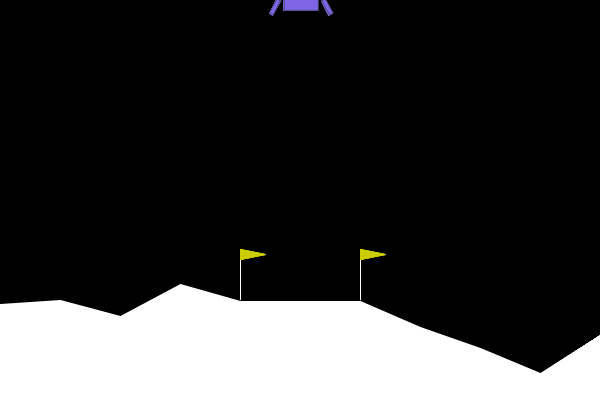

In [15]:
# Naive policies
import gymnasium as gym
env = gym.make("LunarLander-v2", continuous=False, render_mode="rgb_array")
RenderWrapper.register(env, force_gif=True)



state,info = env.reset()
done = False


total_rew = 0
for t in range(300):
    env.render_wrapper.render()

    # action = np.array([-1., 0.])
    # action = np.array([0., 0.])
    #action = env.action_space.sample()   # Random policy
    bucket_state = bucketize(state)
    action = choose_action(qTable, bucket_state, 0)

    state, reward, done, truncated,info = env.step(action)

    total_rew += reward

    if done:
      break

print(total_rew)

env.close()
env.render_wrapper.make_gif("lab7_ex4_explore")

---